<h1 style="text-align: center;">Gradient Descent Without Backpropagation</h1>
<h4 style="text-align: center;">Author: Ignacio &Aacute;vila Reyes</h4>


# Python Libraries

In [31]:
import torch
from matplotlib import pyplot as plt
import functorch as fc
import time
from functools import partial
import src.fwdgrad.loss as fwdloss

# Index


1. [Introduction](#id1)
2. [Getting in touch with the code](#id2)
    + Forward Mode
    + Reverse Mode
3. [More in depth](#id3)
    + Forward Gradient Method
4. [Some simple proofs](#id4)
    + Backpropagation
    + Forward Propagation  
5. [Real-World Applications](#id5)
    + Downloading the MNIST Dataset
    + Defining a DataLoader
    + Defining Fixed Parameters
    + Building the model
    + Backpropagation
        - Training
        - Evaluating
    + Forward Propagation
        - Training
        - Evaluating
    + Comparing Parameters

# Introduction <a name="id1"></a>
<div id='id1' />

Using backpropagation to compute gradients of functios in order to design machine learning has been the order of the day for a long time.

Here we present an alternative method which is called **Forward Gradient** and its main advantage is computing the gradient during the forward step. Roughly speaking, this is an unbiased estimate of the gradient that permits us to entirely remove the backward step during the training of a neural network.

Let's explain briefly each one of the methods:


# Getting in touch with the code
<div id='id2' />


## Forward Mode

Given a function $f:\mathbb{R}^n\longrightarrow\mathbb{R}^m$ and the values $\theta\in\mathbb{R}^n$, $v\in\mathbb{R}^n$. _Forward Mode_ computes $f(\theta)$ and the jacobian vector product $J_f(\theta)\cdot v$ where $v$ is a vector of perturbations. All of this computed in just the **Forward Step**.

<div align="center"><img alt="Forward Step Scheme" src="./src/images/fwdStep.png"></div>

Firstly, let's get in touch with the method:


In [32]:
# Let's try to use CUDA
DEVICE = torch.device(f"cuda:0" if torch.cuda.is_available() else "cpu")
print("Using", torch.cuda.get_device_name(DEVICE))


Using NVIDIA GeForce GTX 1050


In [33]:
# We define an input
input = torch.tensor([[5., 10.]]).to(DEVICE)

# Our random vector
v = torch.randn_like(input)
print(v)

# A function

def f(x):
    return x**2


tensor([[0.8460, 1.3780]], device='cuda:0')


In [34]:
# funtorch.jvp(f, input, vector) returns f(input) and the directional gradient of
# "f" in "input" with direction "vector"
value, grad = fc.jvp(f, (input,), (v.to(DEVICE),))
print("Results:", value)
print("Gradient:", grad)

Results: tensor([[ 25., 100.]], device='cuda:0')
Gradient: tensor([[ 8.4602, 27.5591]], device='cuda:0')


## Reverse Mode

Given a function $f:\mathbb{R}^n\longrightarrow\mathbb{R}^m$ and the values $\theta\in\mathbb{R}^n$, $v\in\mathbb{R}^n$. _Reverse Mode_ computes $f(\theta)$ and the vector-jacobian product $v^T\cdot J_f(\theta)$ where $v$ is a vector of adjoints.

<div align="center"><img alt="Backward Step Scheme" src="./src/images/bckStep.png"></div>

We have already got in touch with this during lab sessions, but let's make some basic calculations:


In [35]:
loss = torch.nn.MSELoss()

# Inputs and expected predictions
input = torch.randn(2, 2, requires_grad=True, device=DEVICE)
target = torch.randn(2, 2, device=DEVICE)

print("Input:", input)
print("Target:", target)

# We define a model with a simple activation layer using the relu
# function
pred = input.relu()
print("Prediction:", pred)
out = loss(input, pred)
print("Output: ", out)
out.backward()

# Gradient
print("Gradient:", input.grad)


Input: tensor([[-0.5737,  0.1774],
        [-2.1294, -1.9355]], device='cuda:0', requires_grad=True)
Target: tensor([[-0.8701, -1.0545],
        [-0.6066,  1.4736]], device='cuda:0')
Prediction: tensor([[0.0000, 0.1774],
        [0.0000, 0.0000]], device='cuda:0', grad_fn=<ReluBackward0>)
Output:  tensor(2.1524, device='cuda:0', grad_fn=<MseLossBackward0>)
Gradient: tensor([[-0.2869,  0.0000],
        [-1.0647, -0.9677]], device='cuda:0')


# More in depth
<div id='id3' />

## Forward Gradient Method

**Definition.** Given a function $f:\mathbb{R}^n\longrightarrow\mathbb{R}$ we define the "**forward gradient**" $g:\mathbb{R}^n\longrightarrow\mathbb{R}^n$ as $g(\theta)=(\nabla f(\theta)\cdot v)\hspace{0.1cm}v)$ where $\theta\in\mathbb{R}^n$ is the point at which we are evaluating the gradient and $v\in\mathbb{R}^n$ is a perturbation vector taken as a multivariate random variable $v\sim p(v)$ such that $v_i$ components has _zero mean_ and _unit variance_. So that $\nabla f(\theta)\cdot v$ is the directional derivative of $f$ at point $\theta$ in direction $v$.

So each time we evaluate the **forward gradient**, we simply do the following:

- Sample random perturbation vector $v\sim p(v)$
- Evaluate $f(\theta)$ and $\nabla f(\theta)\cdot v$ simoultaneously in the same single forward step without having to compute $\nabla f$ at all in the process.
- Multiply the scalar directional derivative $\nabla f(\theta)\cdot v$ and obtain $g(\theta)$, the forward gradient.

<div align="center"><img alt="Forward Gradient Graph" src="./src/images/graph.png"></div>


# Some simple proofs
<div id='id4' />


Let's now make some simple comprobations that will serve us to ensure that both methods obtain the same results. The only difference is that **Backpropagation** is _less time-consuming_ and **Forward Propagation** is _less memory-consuming_.

For doing this checking, we use the given files [global_optimization_backprop.py](./src/global_optimization_backprop.py) and [global_optimization_fwdgrad.py](./src/global_optimization_fwdgrad.py) that just take a random tensor of size (2,1) and compute the **Backward Propagation** and the **Forward Propagation** respectively with the hyperparameters previously defined in [global_optim_config.yaml](./src/configs/global_optim_config.yaml):

- Random Seed: $42$ _(just to generate the same random tensor in both methods)_
- Learning Rate: $10^{-3}$
- Iterations: $5000$


## Backpropagation


In [36]:
!python .\src\global_optimization_backprop.py


^C


Using  NVIDIA GeForce GTX 1050
Iteration [1/5000], Loss: 1.8800, Time (s): 0.5443
Iteration [200/5000], Loss: 0.0031, Time (s): 0.0012
Iteration [399/5000], Loss: 0.0026, Time (s): 0.0014
Iteration [598/5000], Loss: 0.0022, Time (s): 0.0011
Iteration [797/5000], Loss: 0.0018, Time (s): 0.0014
Iteration [996/5000], Loss: 0.0015, Time (s): 0.0017
Iteration [1195/5000], Loss: 0.0013, Time (s): 0.0013
Iteration [1394/5000], Loss: 0.0011, Time (s): 0.0012
Iteration [1593/5000], Loss: 0.0009, Time (s): 0.0012
Iteration [1792/5000], Loss: 0.0008, Time (s): 0.0012
Iteration [1991/5000], Loss: 0.0007, Time (s): 0.0012
Iteration [2190/5000], Loss: 0.0006, Time (s): 0.0012
Iteration [2389/5000], Loss: 0.0005, Time (s): 0.0012
Iteration [2588/5000], Loss: 0.0004, Time (s): 0.0012
Iteration [2787/5000], Loss: 0.0003, Time (s): 0.0012
Iteration [2986/5000], Loss: 0.0003, Time (s): 0.0012
Iteration [3185/5000], Loss: 0.0002, Time (s): 0.0010
Iteration [3384/5000], Loss: 0.0002, Time (s): 0.0012
Itera

## Forward Propagation


In [ ]:
!python .\src\global_optimization_fwdgrad.py


Using  NVIDIA GeForce GTX 1050
Iteration [1/5000], Loss: 1.8800, Time (s): 0.5937
Iteration [200/5000], Loss: 0.0107, Time (s): 0.0015
Iteration [399/5000], Loss: 0.0090, Time (s): 0.0020
Iteration [598/5000], Loss: 0.0060, Time (s): 0.0024
Iteration [797/5000], Loss: 0.0048, Time (s): 0.0022
Iteration [996/5000], Loss: 0.0043, Time (s): 0.0015
Iteration [1195/5000], Loss: 0.0037, Time (s): 0.0015
Iteration [1394/5000], Loss: 0.0023, Time (s): 0.0015
Iteration [1593/5000], Loss: 0.0021, Time (s): 0.0015
Iteration [1792/5000], Loss: 0.0017, Time (s): 0.0016
Iteration [1991/5000], Loss: 0.0015, Time (s): 0.0015
Iteration [2190/5000], Loss: 0.0013, Time (s): 0.0015
Iteration [2389/5000], Loss: 0.0012, Time (s): 0.0016
Iteration [2588/5000], Loss: 0.0010, Time (s): 0.0016
Iteration [2787/5000], Loss: 0.0009, Time (s): 0.0015
Iteration [2986/5000], Loss: 0.0008, Time (s): 0.0016
Iteration [3185/5000], Loss: 0.0006, Time (s): 0.0024
Iteration [3384/5000], Loss: 0.0005, Time (s): 0.0018
Itera

# Real-World Applications
<div id='id5' />


Now that we know how to use these two methods, let's use them with _real-world_ issues. For example, let's use them to build a neural network that classifies the **MNIST dataset**.


### Downloading the MNIST Dataset


In [ ]:
import torchvision.datasets as datasets
from torchvision.transforms import ToTensor


def download_mnist():
    train_data = datasets.MNIST(
        root="./src/datasets",
        download=True,
        train=True,
        transform=ToTensor(),
    )

    target_data = datasets.MNIST(
        root="./src/datasets",
        download=True,
        train=False,
        transform=ToTensor()
    )

    return train_data, target_data


In [ ]:
# Now let's download the dataset

train_data, target_data = download_mnist()
print("MNIST dataset downloaded")


MNIST dataset downloaded


It's also important to observe the data size and type before starting with the calculations:


In [ ]:
print("Training data: ", train_data.data.shape, " ", train_data.data.type())
print("Validation data: ", target_data.data.shape, " ", target_data.data.type())


Training data:  torch.Size([60000, 28, 28])   torch.ByteTensor
Validation data:  torch.Size([10000, 28, 28])   torch.ByteTensor


### Defining a Data Loader

Once we have downloaded the dataset, let's design a **Data Loader** just for preparing the batches for the training.


In [ ]:
from torch.utils.data import DataLoader

BATCHSIZE = 128
NUMWORKERS = 8
train_data_loader = DataLoader(
    train_data,
    batch_size=BATCHSIZE,
    num_workers=NUMWORKERS,
    shuffle=True
)

test_data_loader = DataLoader(
    target_data,
    batch_size=BATCHSIZE,
    num_workers=NUMWORKERS,
    shuffle=True
)


Let's observe how does the batching works:

In [ ]:
for inputs, targets in train_data_loader:
    print("Inputs: ", inputs.shape)
    print("Targets: ", targets.shape, " === ", targets)
    break

Inputs:  torch.Size([128, 1, 28, 28])
Targets:  torch.Size([128])  ===  tensor([1, 8, 9, 9, 1, 3, 9, 3, 4, 6, 8, 9, 8, 7, 4, 4, 7, 6, 6, 7, 0, 5, 6, 4,
        9, 1, 1, 7, 5, 8, 5, 5, 2, 3, 1, 2, 8, 0, 8, 8, 1, 6, 4, 3, 3, 0, 8, 0,
        1, 8, 0, 2, 4, 3, 5, 1, 0, 3, 6, 4, 6, 8, 1, 9, 0, 9, 1, 9, 2, 8, 9, 7,
        6, 2, 2, 1, 6, 5, 8, 4, 8, 4, 0, 4, 8, 6, 0, 4, 2, 1, 7, 6, 3, 8, 2, 3,
        1, 0, 4, 4, 7, 2, 1, 0, 7, 3, 8, 3, 0, 3, 1, 4, 4, 2, 9, 7, 3, 0, 4, 0,
        7, 0, 4, 0, 3, 5, 4, 9])


### Defining Fixed Parameters

In [ ]:
def newParameters(device):
    return [
        torch.FloatTensor(28*28, 128).uniform_(-1,1).requires_grad_(True).to(device),
        torch.FloatTensor(128).uniform_(-1,1).requires_grad_(True).to(device),
        torch.FloatTensor(128, 64).uniform_(-1,1).requires_grad_(True).to(device),
        torch.FloatTensor(64).uniform_(-1,1).requires_grad_(True).to(device),
        torch.FloatTensor(64, 10).uniform_(-1,1).requires_grad_(True).to(device),
        torch.FloatTensor(10).uniform_(-1,1).requires_grad_(True).to(device)
    ]

parameters = newParameters(DEVICE)
print(parameters[5])

tensor([-0.5624,  0.2481,  0.6887, -0.1788, -0.5917, -0.4597, -0.2185, -0.3323,
         0.0229,  0.1176], device='cuda:0', grad_fn=<ToCopyBackward0>)


### Building the model

Then we create our Neural Network that inherits `torch.nn`:


In [ ]:
from torch import nn

class MultiLayer(nn.Module):
    def __init__(self, params) -> None:
        super().__init__()

        self.relu = nn.ReLU()
        self.flatten = nn.Flatten()
        self.softmax = nn.Softmax(1)

        self.w1 = nn.Parameter(params[0])
        self.b1 = nn.Parameter(params[1])

        self.w2 = nn.Parameter(params[2])
        self.b2 = nn.Parameter(params[3])
        
        self.w3 = nn.Parameter(params[4])
        self.b3 = nn.Parameter(params[5])
        

    def forward(self, input_data) -> torch.Tensor:
        flat_data = self.flatten(input_data)
        x = self.relu(flat_data @ self.w1 + self.b1)
        x = self.relu(x @ self.w2 + self.b2)
        logits = self.softmax(x @ self.w3 + self.b3)
        return logits


And now we define another necessary function:

In [ ]:
# A function to compute losses
def cross_entropy(predictions, targets):
  return torch.abs(torch.gather(predictions + 1e-15 ,0,targets.reshape(-1,1)).log().mean())

Let's do some proofs:

In [ ]:
# We initialize an instance of the previously defined network
params_proof = parameters.copy()
mnn = MultiLayer(params_proof).to(DEVICE)

# We try our model with some first examples (one batch of size BATCHSIZE)
loss_fn = cross_entropy

for batch in train_data_loader:

    w1, b1, w2, b2, w3, b3 = list(mnn.parameters())

    inputs = batch[0].to(DEVICE).requires_grad_(True)
    targets = batch[1].to(DEVICE)

    predictions = mnn(inputs)

    loss = loss_fn(predictions, targets)
    print("Loss: ", loss)

    grads = torch.autograd.grad(loss,[w1, b1, w2, b2, w3, b3])

    with torch.no_grad():

        print(grads[0].shape)
        print(grads[1].shape)
        print(grads[2].shape)
        print(grads[3].shape)
        print(grads[4].shape)
        print("Grad:", grads[5].shape, " === ", grads[5])

    break

Loss:  tensor(33.7056, device='cuda:0', grad_fn=<AbsBackward0>)
torch.Size([784, 128])
torch.Size([128])
torch.Size([128, 64])
torch.Size([64])
torch.Size([64, 10])
Grad: torch.Size([10])  ===  tensor([-1.1709e-01,  1.6511e-12,  1.1633e-08,  0.0000e+00,  1.1758e-40,
         9.1819e-31,  0.0000e+00,  2.8515e-40,  1.1709e-01,  1.4843e-41],
       device='cuda:0')


### Backpropagation

#### Training the model

We now code the training loop for brackpropagation:

- `BackTrain`


In [ ]:
def BackEpoch(model, data_loader, loss_fn, learning_rate, device) -> None:
    # Initialize some auxiliar variables
    losses = []

    # Start time of the Epoch
    t0 = time.perf_counter()

    for it, batch in enumerate(data_loader): 

        inputs = batch[0].to(device).requires_grad_(True)
        targets = batch[1].to(device)

        # Start time of iteration
        t2 = time.perf_counter()
        
        # We predict the inputs
        predictions = model(inputs)
        
        # Calculate Loss
        loss = loss_fn(predictions, targets)
        losses.append(loss.item())

        # BackPropagate Loss and Update Weights
        grads = torch.autograd.grad(loss, list(model.parameters()))

        [w1, b1, w2, b2, w3, b3] = list(model.parameters())

        with torch.no_grad():

            # Apply gradients
            w1 -= learning_rate * grads[0]
            b1 -= learning_rate * grads[1]

            w2 -= learning_rate * grads[2]
            b2 -= learning_rate * grads[3]
            
            w3 -= learning_rate * grads[4]
            b3 -= learning_rate * grads[5]           

        # End time of iteration
        t3 = time.perf_counter()

        # We sometimes print some information to follow the learning of the network as a process
        if it % 100 == 0:
            print(f"Iteration {it:4d}, Loss: {loss:.4f}, It. Time: {t3 - t2:.4f} s")
            

        # We reasign the new values to the parameters of the model:
        model.register_parameter("w1",w1)
        model.register_parameter("b1",b1)

        model.register_parameter("w2",w2)
        model.register_parameter("b2",b2)

        model.register_parameter("w3",w3)
        model.register_parameter("b3",b3)
    
    # End time of the Epoch
    t1 = time.perf_counter()
    
    # Let's plot the losses and the Epoch Results
    plt.plot(losses)
    plt.show()
    print("\nEPOCH RESULTS")
    print(f"Loss: {sum(losses)/len(losses):.4f}")
    print(f"Time: {t1-t0:.4f} s")


def BackTrain(model, data_loader, loss_fn, learning_rate, device, epochs) -> None:
    print("=== === === === === === === === === === === ===")
    print("Using", torch.cuda.get_device_name(device))

    for i in range(epochs):
        print(f"---------------- EPOCH {i+1} -------------------")

        BackEpoch(
            model=model,
            data_loader=data_loader,
            loss_fn=loss_fn,
            learning_rate=learning_rate,
            device=device
        )
        
        print("-------------------------------------------------") 
    print("Training Finished")
    print("=== === === === === === === === === === === ===")


=== === === === === === === === === === === ===
Using NVIDIA GeForce GTX 1050
---------------- EPOCH 1 -------------------
Iteration    0, Loss: 34.5388, It. Time: 0.0020 s
Iteration  100, Loss: 34.5388, It. Time: 0.0018 s
Iteration  200, Loss: 34.2280, It. Time: 0.0026 s
Iteration  300, Loss: 29.7855, It. Time: 0.0020 s
Iteration  400, Loss: 30.2214, It. Time: 0.0024 s


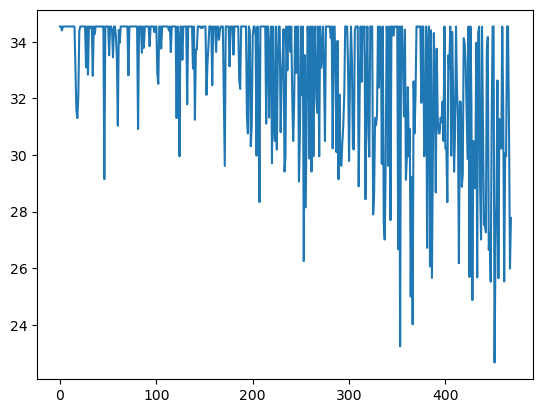


EPOCH RESULTS
Loss: 32.8267
Time: 6.3458 s
-------------------------------------------------
---------------- EPOCH 2 -------------------
Iteration    0, Loss: 26.6533, It. Time: 0.0026 s
Iteration  100, Loss: 25.5100, It. Time: 0.0019 s
Iteration  200, Loss: 17.6458, It. Time: 0.0028 s
Iteration  300, Loss: 10.1596, It. Time: 0.0017 s
Iteration  400, Loss: 3.5078, It. Time: 0.0021 s


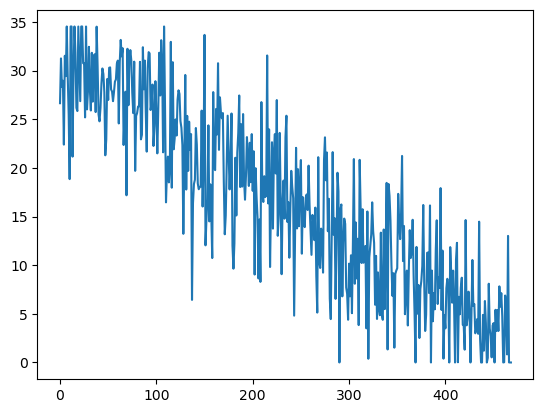


EPOCH RESULTS
Loss: 16.7581
Time: 6.4078 s
-------------------------------------------------
---------------- EPOCH 3 -------------------
Iteration    0, Loss: 0.7827, It. Time: 0.0016 s
Iteration  100, Loss: 5.7619, It. Time: 0.0028 s
Iteration  200, Loss: 0.0000, It. Time: 0.0022 s
Iteration  300, Loss: 0.5131, It. Time: 0.0018 s
Iteration  400, Loss: 0.0000, It. Time: 0.0024 s


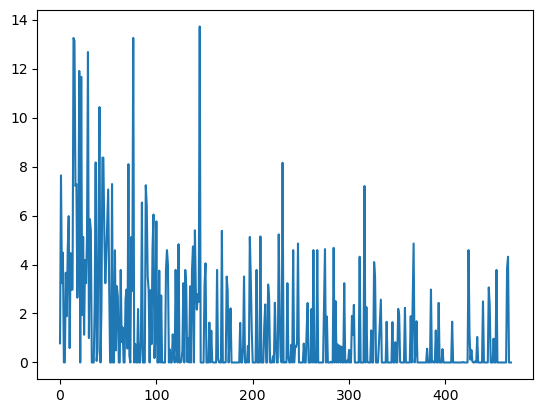


EPOCH RESULTS
Loss: 1.4075
Time: 6.9097 s
-------------------------------------------------
---------------- EPOCH 4 -------------------
Iteration    0, Loss: 3.5078, It. Time: 0.0026 s
Iteration  100, Loss: 0.9373, It. Time: 0.0019 s
Iteration  200, Loss: 0.0000, It. Time: 0.0019 s
Iteration  300, Loss: 0.0000, It. Time: 0.0022 s
Iteration  400, Loss: 0.0000, It. Time: 0.0019 s


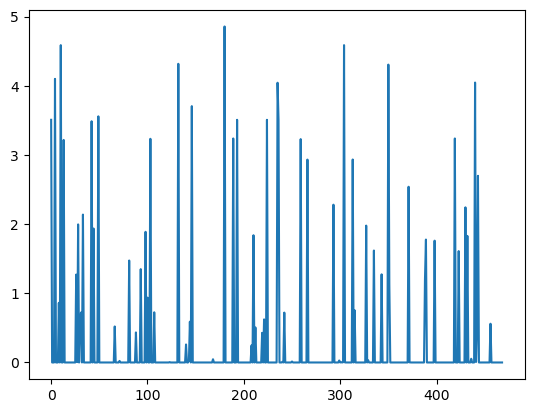


EPOCH RESULTS
Loss: 0.2765
Time: 6.2644 s
-------------------------------------------------
---------------- EPOCH 5 -------------------
Iteration    0, Loss: 0.0000, It. Time: 0.0027 s
Iteration  100, Loss: 0.0000, It. Time: 0.0028 s
Iteration  200, Loss: 0.0000, It. Time: 0.0021 s
Iteration  300, Loss: 0.0000, It. Time: 0.0024 s
Iteration  400, Loss: 0.0000, It. Time: 0.0028 s


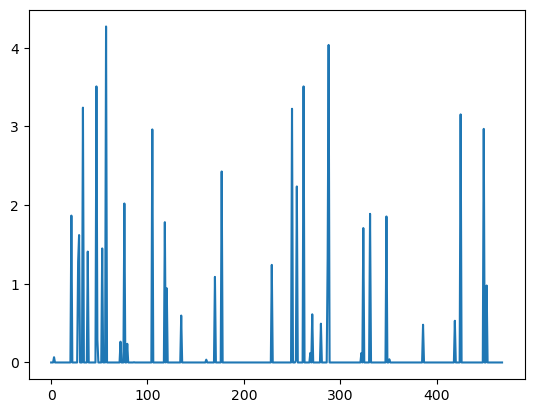


EPOCH RESULTS
Loss: 0.1320
Time: 6.3601 s
-------------------------------------------------
Training Finished
=== === === === === === === === === === === ===


In [ ]:
LR = 1e-4
EPOCHS = 5
DEVICE = torch.device(
    f"cuda:0" if torch.cuda.is_available()
    else "cpu"
)

params_back = parameters.copy()
Back_NeuralNetwork = MultiLayer(params_back).to(DEVICE)

BackTrain(
    model=Back_NeuralNetwork,
    data_loader=train_data_loader,
    loss_fn=cross_entropy,
    learning_rate=LR,
    device=DEVICE,
    epochs=EPOCHS
)


We can see that in each epoch the loss decreases, just how we wanted. 

#### Evaluating the model

Now we are going to evaluate the network testing with the validation data:


In [ ]:
def BackEval(model, data_loader, loss_fn, device) -> None:

    # Initialize some auxiliar variables
    losses = []

    # Start time of the Evaluation
    t0 = time.perf_counter()

    for it, batch in enumerate(data_loader): 

        inputs = batch[0].to(device).requires_grad_(True)
        targets = batch[1].to(device)

        # Start time of iteration
        t2 = time.perf_counter()
        
        # We predict the inputs
        predictions = model(inputs)
        
        # Calculate Loss
        loss = loss_fn(predictions, targets)
        losses.append(loss.item())

        # End time of iteration
        t3 = time.perf_counter()

        # We sometimes print some information to follow the evaluation of the network as a process
        if it % 10 == 0:
            print(f"Iteration {it:4d}, Loss: {loss:.4f}, It. Time: {t3 - t2:.4f} s")
            
    # End time of the Evaluation
    t1 = time.perf_counter()
    
    # Let's plot the losses and the Epoch Results
    plt.plot(losses, 'o')
    plt.show()
    print("Evaluation RESULTS")
    print(f"Loss: {sum(losses)/len(losses):.4f}")
    print(f"Time: {t1-t0:.4f} s")



Iteration    0, Loss: 0.0000, It. Time: 0.0006 s
Iteration   10, Loss: 0.0006, It. Time: 0.0008 s
Iteration   20, Loss: 0.0000, It. Time: 0.0008 s
Iteration   30, Loss: 0.0000, It. Time: 0.0008 s
Iteration   40, Loss: 0.0000, It. Time: 0.0006 s
Iteration   50, Loss: 0.0000, It. Time: 0.0008 s
Iteration   60, Loss: 0.0000, It. Time: 0.0010 s
Iteration   70, Loss: 0.0000, It. Time: 0.0009 s


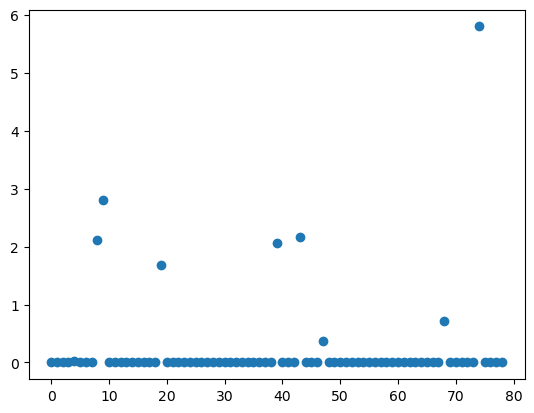

Evaluation RESULTS
Loss: 0.2250
Time: 4.9345 s


In [ ]:
BackEval(
    model=Back_NeuralNetwork,
    data_loader=test_data_loader,
    loss_fn=cross_entropy,
    device=DEVICE
)

### Forward Propagation

#### Training the model

We now code the training loop for forward propagation:

- `FwdTrain`


In [21]:
def FwdEpoch(functional_model,params, data_loader, loss_fn, learning_rate, device) -> None:

    # Initialize some auxiliar variables
    losses = []

    # Start time of the Epoch
    t0 = time.perf_counter()

    for it, batch in enumerate(data_loader): 

        inputs = batch[0].to(device).requires_grad_(True)
        targets = batch[1].to(device)

        # Start time of iteration
        t2 = time.perf_counter()

        # Sample perturbation (tangent) vectors for every parameter of the model
        v_params = tuple([torch.randn_like(p).to(device) for p in params])
        f = partial(
            loss_fn,
            model=functional_model,
            x=inputs,
            t=targets
        )

        # We compute the Forward Propagation
        loss, jvp = fc.jvp(f, (tuple(params),), (v_params,))
        losses.append(loss.item())
        
        with torch.no_grad():
            
            for j, p in enumerate(params):
                    p.sub_(learning_rate * jvp * v_params[j]) 

        # End time of iteration
        t3 = time.perf_counter()

        # We sometimes print some information to follow the learning of the network as a process
        if it % 100 == 0:
            print(f"Iteration {it:4d}, Loss: {loss:.4f}, It. Time: {t3 - t2:.4f} s")

    # End time of the Epoch
    t1 = time.perf_counter()
    
    # Let's plot the losses and the Epoch Results
    plt.plot(losses)
    plt.show()
    print("\nEPOCH RESULTS")
    print(f"Loss: {sum(losses)/len(losses):.4f}")
    print(f"Time: {t1-t0:.4f} s")


def FwdTrain(model, data_loader, loss_fn, learning_rate, device, epochs) -> None:
    
    print("=== === === === === === === === === === === ===")
    print("Using", torch.cuda.get_device_name(device))

    # We first get the functional version of the model with funtorch
    functional_model, func_params = fc.make_functional(model)

    for i in range(epochs):
        print(f"---------------- EPOCH {i+1} -------------------")

        FwdEpoch(
            functional_model=functional_model,
            params = func_params,
            data_loader=data_loader,
            loss_fn=loss_fn,
            learning_rate=learning_rate,
            device=device
        )
        
        print("-------------------------------------------------") 
    print("Training Finished")
    print("=== === === === === === === === === === === ===")


=== === === === === === === === === === === ===
Using NVIDIA GeForce GTX 1050
---------------- EPOCH 1 -------------------
Iteration    0, Loss: 2.3673, It. Time: 0.0059 s
Iteration  100, Loss: 2.3752, It. Time: 0.0040 s
Iteration  200, Loss: 2.3440, It. Time: 0.0040 s
Iteration  300, Loss: 2.3758, It. Time: 0.0037 s
Iteration  400, Loss: 2.3437, It. Time: 0.0040 s


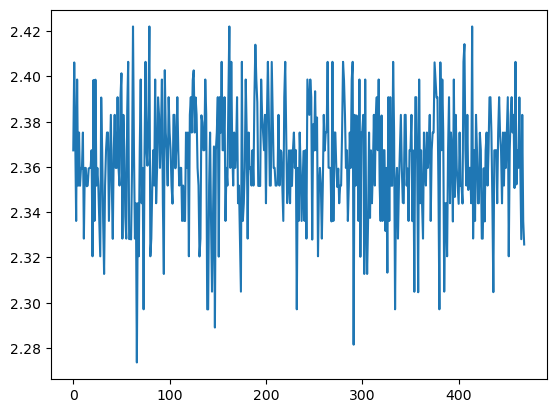


EPOCH RESULTS
Loss: 2.3625
Time: 6.7904 s
-------------------------------------------------
---------------- EPOCH 2 -------------------
Iteration    0, Loss: 2.3204, It. Time: 0.0047 s
Iteration  100, Loss: 2.3596, It. Time: 0.0043 s
Iteration  200, Loss: 2.3752, It. Time: 0.0040 s
Iteration  300, Loss: 2.3752, It. Time: 0.0038 s
Iteration  400, Loss: 2.3908, It. Time: 0.0041 s


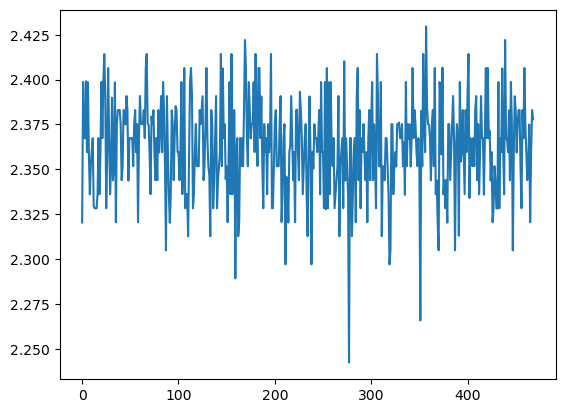


EPOCH RESULTS
Loss: 2.3625
Time: 7.2090 s
-------------------------------------------------
---------------- EPOCH 3 -------------------
Iteration    0, Loss: 2.3440, It. Time: 0.0062 s
Iteration  100, Loss: 2.3752, It. Time: 0.0040 s
Iteration  200, Loss: 2.4221, It. Time: 0.0065 s
Iteration  300, Loss: 2.3987, It. Time: 0.0045 s
Iteration  400, Loss: 2.3596, It. Time: 0.0040 s


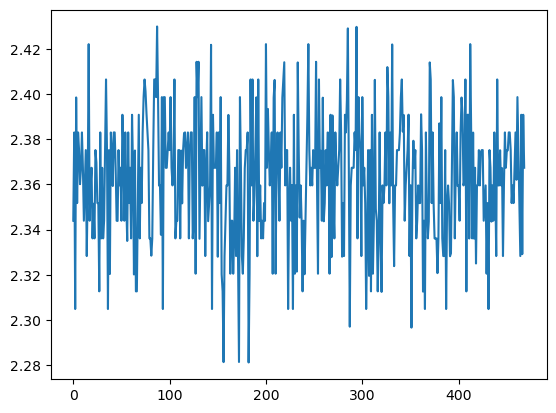


EPOCH RESULTS
Loss: 2.3625
Time: 6.9095 s
-------------------------------------------------
---------------- EPOCH 4 -------------------
Iteration    0, Loss: 2.4143, It. Time: 0.0117 s
Iteration  100, Loss: 2.3596, It. Time: 0.0043 s
Iteration  200, Loss: 2.3593, It. Time: 0.0041 s
Iteration  300, Loss: 2.3518, It. Time: 0.0042 s
Iteration  400, Loss: 2.2893, It. Time: 0.0035 s


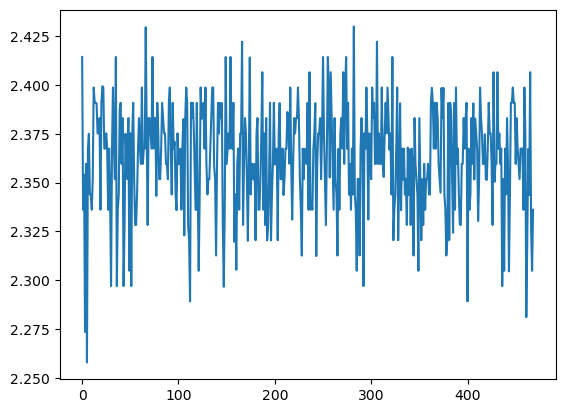


EPOCH RESULTS
Loss: 2.3625
Time: 7.0997 s
-------------------------------------------------
---------------- EPOCH 5 -------------------
Iteration    0, Loss: 2.3752, It. Time: 0.0066 s
Iteration  100, Loss: 2.3114, It. Time: 0.0041 s
Iteration  200, Loss: 2.3674, It. Time: 0.0055 s
Iteration  300, Loss: 2.3064, It. Time: 0.0045 s
Iteration  400, Loss: 2.3518, It. Time: 0.0043 s


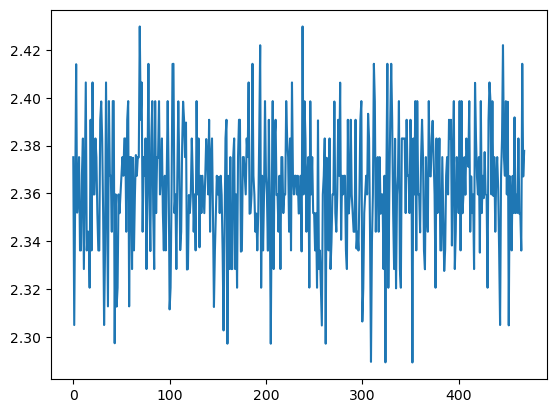


EPOCH RESULTS
Loss: 2.3625
Time: 7.6412 s
-------------------------------------------------
Training Finished
=== === === === === === === === === === === ===


In [29]:
LR = 1e-4
EPOCHS = 5
DEVICE = torch.device(
    f"cuda:0" if torch.cuda.is_available()
    else "cpu"
)

params_fwd = parameters.copy()
Fwd_NeuralNetwork = MultiLayer(params_fwd).to(DEVICE)

FwdTrain(
    model=Fwd_NeuralNetwork,
    data_loader=train_data_loader,
    loss_fn=fwdloss.functional_xent,
    learning_rate=LR,
    device=DEVICE,
    epochs=EPOCHS
)

#### Evaluating the model

Now we are going to evaluate the network testing with the validation data:

## Comparing Parameters

In [30]:
print("initial:", parameters[5])
print("back:", list(Back_NeuralNetwork.parameters())[5])
print("forward:",list(Fwd_NeuralNetwork.parameters())[5])

initial: tensor([-0.5528,  0.2461,  0.6884, -0.1815, -0.5928, -0.4597, -0.2185, -0.3325,
         0.0197,  0.1176], device='cuda:0', grad_fn=<ToCopyBackward0>)
back: Parameter containing:
tensor([-0.5528,  0.2461,  0.6884, -0.1815, -0.5928, -0.4597, -0.2185, -0.3325,
         0.0197,  0.1176], device='cuda:0', requires_grad=True)
forward: Parameter containing:
tensor([-0.5528,  0.2461,  0.6884, -0.1815, -0.5928, -0.4597, -0.2185, -0.3325,
         0.0197,  0.1176], device='cuda:0', requires_grad=True)
